In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path


In [2]:
def load_data(csv_file):
    """Charge les données depuis un fichier CSV."""
    data = pd.read_csv(csv_file)
    # Suppression des colonnes non numériques, ici 'timestamp' et 'Unnamed: 0'
    df_numeric = data.drop(['timestamp', 'Unnamed: 0'], axis=1, errors='ignore')
    return df_numeric  # Retourne un DataFrame

In [3]:
def preprocess_data(data):
    """Normalise les données."""
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled


In [4]:
data_path = Path("C:/Users/MSI/Desktop/Mlops/data/MetroPT3(AirCompressor).csv")
print(f"Chemin absolu du fichier : {data_path.resolve()}")

Chemin absolu du fichier : C:\Users\MSI\Desktop\Mlops\data\MetroPT3(AirCompressor).csv


In [5]:
# Charger et prétraiter les données
df_numeric = load_data(data_path)
data_scaled = preprocess_data(df_numeric)

In [6]:
def build_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)

    autoencoder_model = Model(inputs = input_layer, outputs = decoder)
    autoencoder_model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    return autoencoder_model

In [7]:
def train_autoencoder_model(autoencoder_model, x_train, epochs = 50, batch_size = 256):
    history = autoencoder_model.fit(x_train, x_train,
                          epochs = epochs,
                          batch_size=batch_size,
                          shuffle = True,
                          validation_split=0.2,  # Optionnel : pour voir la perte sur les données de validation
                                    verbose=1)  # Affiche la progression de l'entraînement
    return history

In [9]:
# Dimensions des données
input_dim = data_scaled.shape[1]
# Exemple : Choix d'encoding_dim
encoding_dim = 32
autoencoder_model = build_autoencoder(input_dim, encoding_dim)
history = train_autoencoder_model(autoencoder_model, data_scaled, epochs=10)
loss = autoencoder_model.evaluate(data_scaled, data_scaled)
print(f'Encoding dim: {encoding_dim}, Loss: {loss}')

Epoch 1/10
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 5s 846us/step - loss: 0.2005 - val_loss: 0.1550
Epoch 2/10
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 4s 735us/step - loss: 0.1426 - val_loss: 0.1408
Epoch 3/10
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 3s 628us/step - loss: 0.1424 - val_loss: 0.1396
Epoch 4/10
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 3s 593us/step - loss: 0.1423 - val_loss: 0.1391
Epoch 5/10
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 3s 592us/step - loss: 0.1423 - val_loss: 0.1389
Epoch 6/10
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 3s 595us/step - loss: 0.1423 - val_loss: 0.1388
Epoch 7/10
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 3s 580us/step - loss: 0.1422 - val_loss: 0.1387
Epoch 8/10
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 3s 690us/step - loss: 0.1422 - val_loss: 0.1387
Epoch 9/10
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 4s 736us/step - loss: 0.1422 - val_loss: 0.1387
Epoch 10/10
4741/4741 ━━━━━━━━━━━━━━━━━━━━ 3s 620us/step - loss: 0.1422 - val_loss: 0.1386
47405/47405 ━━━━━━━━━━━━━━━━━━━━ 16s 338us/step - loss: 0.1399
Encoding dim: 32, Loss: 0.1414927542

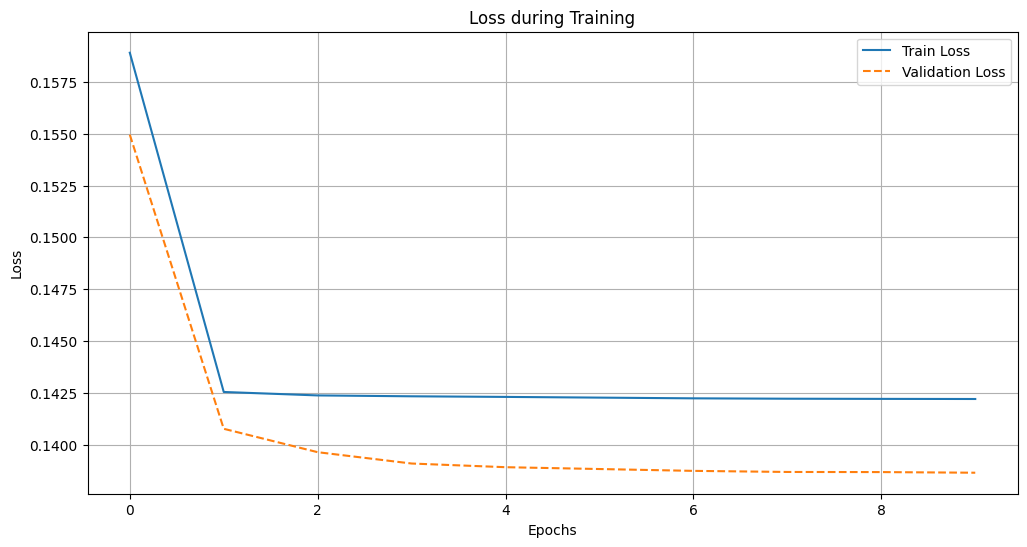

In [10]:
# Tracer la courbe de perte
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')  # Optionnel
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Dans un autoencoder, l'accuracy n'est pas une métrique classique car l’objectif principal est de minimiser la reconstruction loss, souvent calculée par une métrique comme Mean Squared Error (MSE) ou Binary Cross-Entropy.

Différence entre la perte d'entraînement et la perte de validation :

On observe que la perte de validation (courbe orange) est plus basse que la perte d'entraînement (courbe bleue). Cela peut arriver :
Si les données de validation sont un peu plus faciles à reconstruire que celles d'entraînement.
Ou si l'entraînement du modèle est légèrement régularisé (via dropout, batch normalization, ou autres techniques).
Pas de sur-apprentissage (overfitting) :

Il n'y a pas de divergence significative entre la perte d'entraînement et de validation. Cela signifie que le modèle généralise bien et qu'il n'est pas en sur-apprentissage.
Régler la dimension latente (encoding_dim) : Un test avec différentes valeurs (par exemple, 16, 64) pourrait montrer si une autre configuration donne de meilleurs résultats.
Ajuster le learning rate : Si la courbe stagne trop tôt, diminuer légèrement le taux d'apprentissage pourrait permettre d'apprendre plus en profondeur.

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Charger et prétraiter les données
scaler = MinMaxScaler()  # Déclarer le scaler ici pour utiliser plus tard

# Appliquer MinMaxScaler et garder l'objet pour la transformation inverse
data_scaled = scaler.fit_transform(df_numeric)

# Prévision avec l'autoencodeur
reconstructed_data = autoencoder_model.predict(data_scaled)

# **Inverser la normalisation** pour les données reconstruites
reconstructed_data_original_scale = scaler.inverse_transform(reconstructed_data)

# Créer un DataFrame avec les données reconstruites sur l'échelle originale
reconstructed_df = pd.DataFrame(reconstructed_data_original_scale, columns=df_numeric.columns)


# S'assurer que reconstructed_data a la bonne forme
print(f"Shape des données reconstruites : {reconstructed_data.shape}")
print(f"Shape des données originales : {df_numeric.shape}")


47405/47405 ━━━━━━━━━━━━━━━━━━━━ 19s 396us/step
Shape des données reconstruites : (1516948, 15)
Shape des données originales : (1516948, 15)


C:\Users\MSI\AppData\Local\Temp\ipykernel_20428\3512166185.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


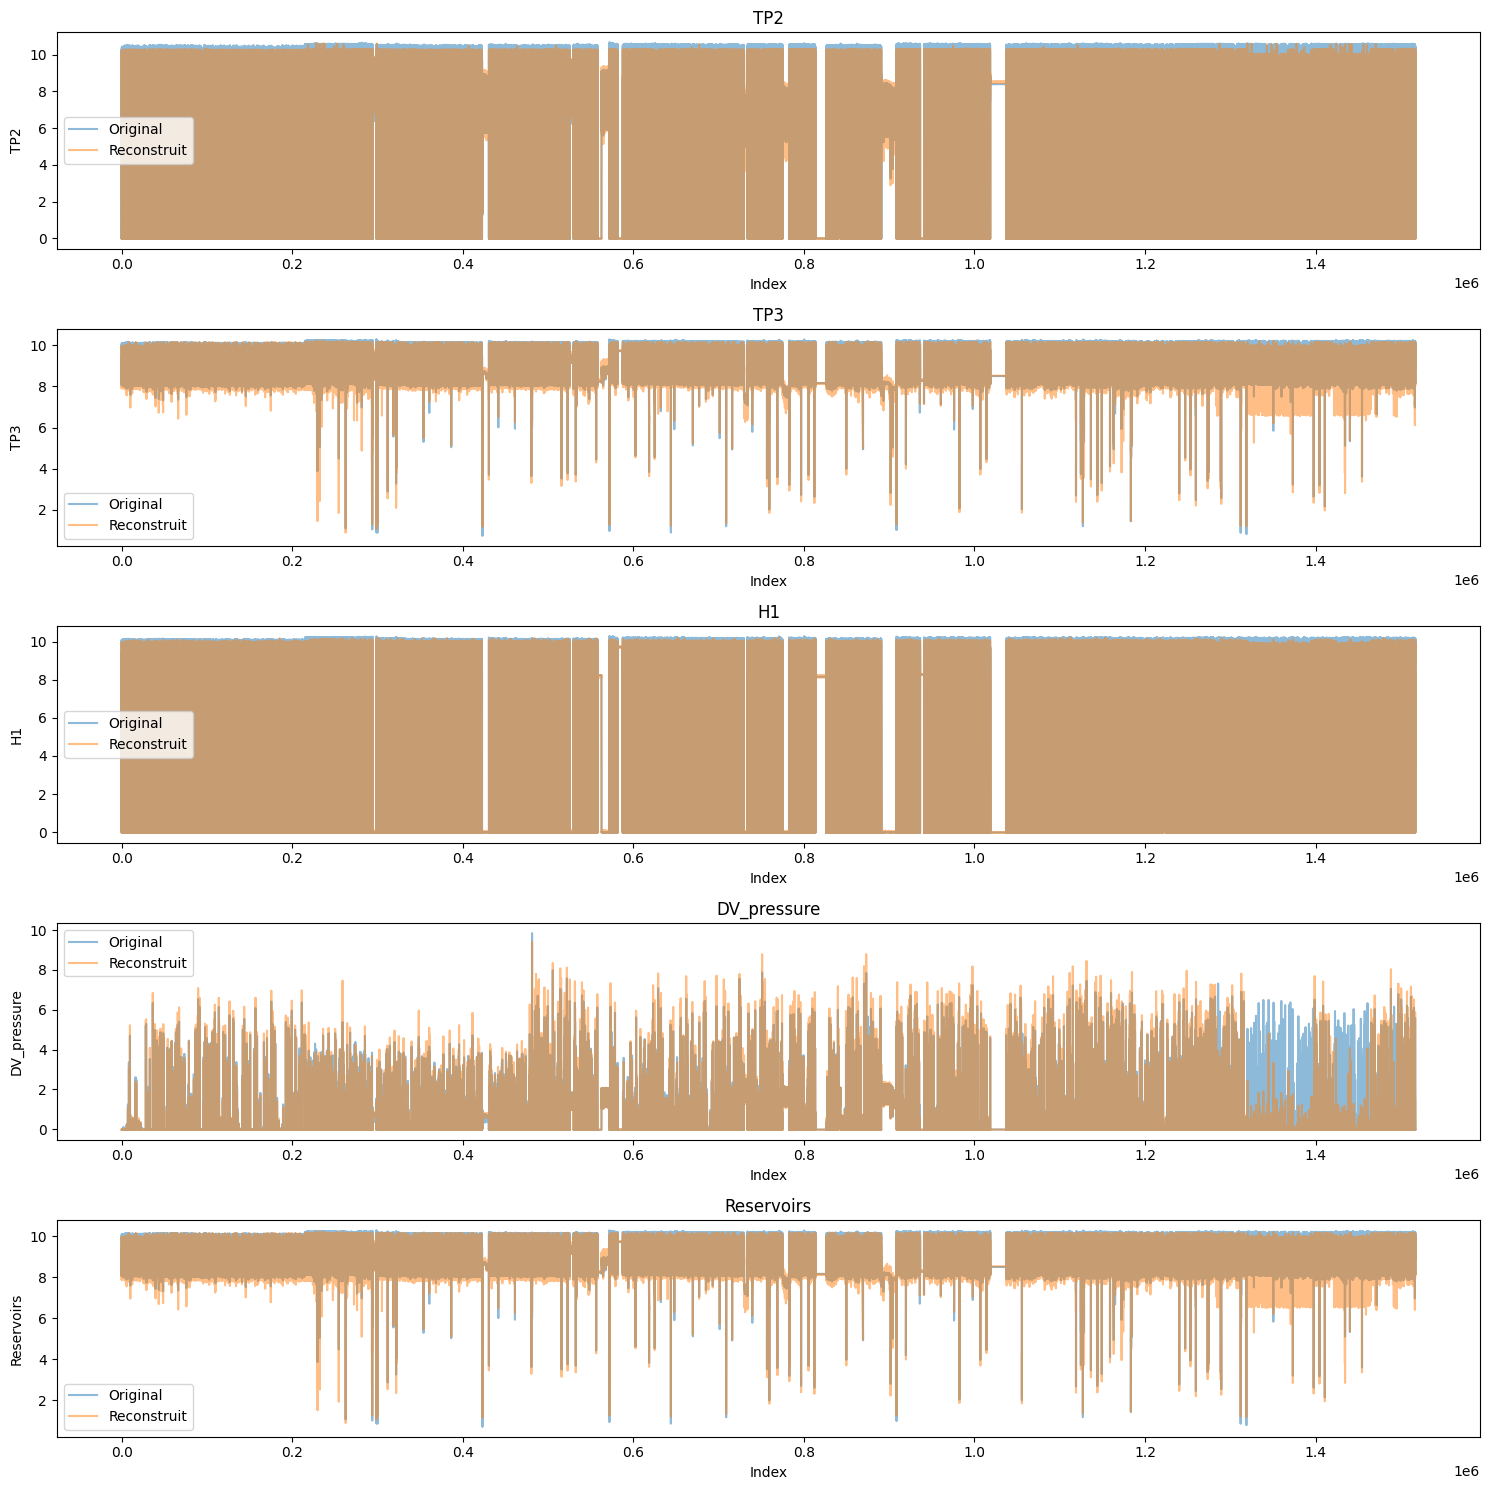

In [12]:
import matplotlib.pyplot as plt
import pandas as pd


# Fonction de visualisation
def visualize_results(original_data, reconstructed_data, feature_names=None, num_features=5):
    """
    Visualiser les résultats de l'autoencodeur en comparant les données d'entrée
    et les données reconstruites.

    Parameters:
    - original_data : Les données originales (input)
    - reconstructed_data : Les données reconstruites par l'autoencodeur
    - feature_names : Liste des noms des caractéristiques à visualiser
    - num_features : Nombre de caractéristiques à visualiser
    """

    if feature_names is None:
        feature_names = original_data.columns.tolist()

    num_features = min(num_features, len(feature_names))

    plt.figure(figsize=(15, num_features * 3))

    for i in range(num_features):
        plt.subplot(num_features, 1, i + 1)
        plt.plot(original_data.index, original_data[feature_names[i]], label='Original', alpha=0.5)
        plt.plot(original_data.index, reconstructed_data[feature_names[i]], label='Reconstruit', alpha=0.5)
        plt.title(feature_names[i])
        plt.xlabel('Index')
        plt.ylabel(feature_names[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Visualiser les résultats avec les données reconstruites sur l'échelle d'origine
visualize_results(df_numeric, reconstructed_df, feature_names=df_numeric.columns.tolist(), num_features=5)

In [13]:
from sklearn.metrics import root_mean_squared_error

# Prévisions (reconstructions) de l'autoencoder
reconstructed_data = autoencoder_model.predict(data_scaled)

# Calcul du MSE entre les données originales et reconstruites
rmse = root_mean_squared_error(data_scaled.flatten(), reconstructed_data.flatten())

print(f'Encoding dim: {encoding_dim}, Loss: {loss}, MSE: {rmse:.4f}')


47405/47405 ━━━━━━━━━━━━━━━━━━━━ 19s 385us/step
Encoding dim: 32, Loss: 0.14149275422096252, MSE: 0.0067


## Exemple de Visualisation des Erreurs de Reconstruction

Seuil de détection des anomalies : 0.00014530392559601132


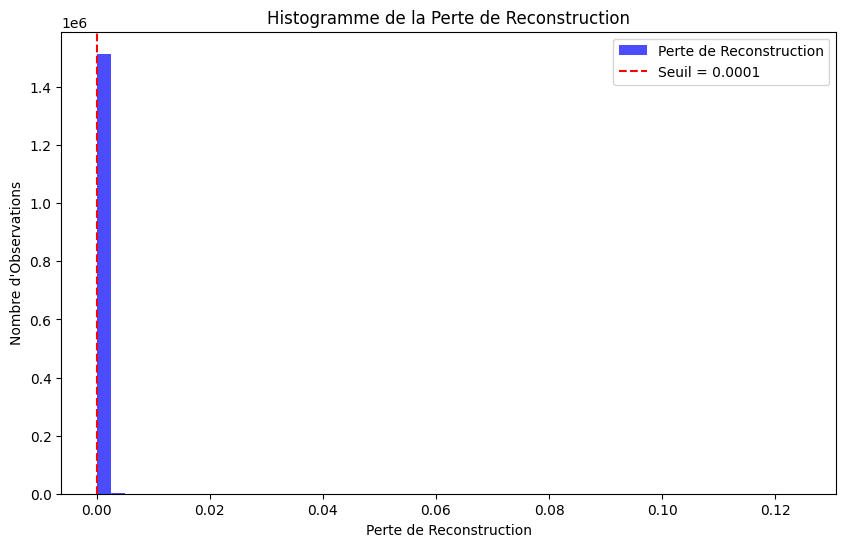

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Calculer la perte de reconstruction (MSE pour chaque observation)
reconstruction_loss = np.mean(np.square(data_scaled - reconstructed_data), axis=1)

# **Définir un seuil** basé sur le 95e quantile des pertes de reconstruction
threshold = np.quantile(reconstruction_loss, 0.95)
print(f"Seuil de détection des anomalies : {threshold}")

# Visualiser la perte de reconstruction
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss, bins=50, alpha=0.7, color='blue', label='Perte de Reconstruction')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Seuil = {threshold:.4f}')
plt.title('Histogramme de la Perte de Reconstruction')
plt.xlabel('Perte de Reconstruction')
plt.ylabel('Nombre d\'Observations')
plt.legend()
plt.show()


## Définir un seuil

In [15]:
# Définir un seuil basé sur le 95ème percentile
threshold = np.percentile(reconstruction_loss, 95)
print(f'Seuil défini à: {threshold}')

Seuil défini à: 0.00014530392559601132


## Silhouette Score
Le Silhouette Score mesure à quel point un point est similaire à son propre cluster par rapport aux autres clusters. La valeur varie de -1 à 1 :

### 1 signifie que le point est bien regroupé.
### 0 signifie que le point est sur la frontière entre deux clusters.
### -1 signifie que le point est mal classé.

In [16]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Appliquer KMeans
n_clusters = 2  
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(reconstructed_data)

# Calculer le Silhouette Score
silhouette_avg = silhouette_score(reconstructed_data, clusters)
print(f'Silhouette Score: {silhouette_avg}')

# Visualiser les clusters
plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k')
plt.title('Clusters de KMeans')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


KeyboardInterrupt: 

##  Dunn Index
Le Dunn Index évalue la qualité de la séparation des clusters. Il est défini comme le rapport entre la plus petite distance inter-cluster et la plus grande distance intra-cluster. Un Dunn Index plus élevé indique une meilleure séparation des clusters.

In [17]:
from scipy.spatial.distance import cdist

def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            # Distance entre clusters
            cluster_i = data[labels == unique_labels[i]]
            cluster_j = data[labels == unique_labels[j]]
            inter_distance = np.min(cdist(cluster_i, cluster_j))
            inter_cluster_distances.append(inter_distance)

    for label in unique_labels:
        # Distance au sein du cluster
        cluster = data[labels == label]
        if len(cluster) > 1:
            intra_distance = np.max(cdist(cluster, cluster))
            intra_cluster_distances.append(intra_distance)

    # Retourner le ratio
    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

# Calculer le Dunn Index
dunn_idx = dunn_index(reconstructed_data, clusters)
print(f'Dunn Index: {dunn_idx}')


MemoryError: Unable to allocate 824. GiB for an array with shape (447154, 247466) and data type float64